# Algorimos Metaheurísticos

Existe una gran diversidad de algoritmos metaheurísticos para solucionar problemas.

Los problemas se plantean como problemas de optimización y exploración de espacios.

## Algoritmo de Templado Simulado

El algoritmo de templado simulado, recocido simulado o simplemente __SA__ (_Simulated Annealing_) es un algorimo metaheurístico de tipo local basado en un proceso termodinámico.

Comenzaremos por proponer una abtracción de un problema de búsqueda local.

In [1]:
from abc import ABCMeta, abstractmethod
class LocalSearchProblem:
    """
    Un problema de búsqueda local
    """
    __metaclass__ = ABCMeta
    
    @abstractmethod
    def aleatoria(self):
        """
        Obtiene un estado aleatorio del problema
        :return: un estado aleatorio
        """
        pass
    
    @abstractmethod
    def energia(self,x):
        """
        Calcula la energía de un estado
        :param x: el estado al que se calculará la energía
        :return: la energía del estado
        """
        pass
    
    def move(self,x):
        """
        Una solución vecina a un estado dado
        :param x: la solución de referencia
        :return: una solución vecina a x
        """
        pass
    
    def show(self,x):
        """
        Muestra graficamente la solución x
        :param x: el estado a mostrar
        """
        pass

Utilizando la definición de __LocalSearchProblem__ podemos definir el algoritmo __SA__.

In [2]:
import numpy as np
class SimulatedAnnealing:
    """
    Implementación del algoritmo de templado simulado
    """
    
    @staticmethod
    def search(problema,c_enfriamiento,Tinit,Tend,n,K=10):
        """
        Busqueda SA
        :param problema: el problema a resolver
        :param c_enfriamiento: constante de enfriamiento
        :param Tinit: temperatura inicial
        :param Tend: temperatura final
        :param n: número de iteraciones a cada temperatura
        (iteraciones para equilibrio térmico)
        :return: una tupla con el estado de menor energía 
        como primer elemento y su energía como segundo.
        """
        # Obtenemos del problema una solución aleatoria
        x = problema.aleatoria()
        # Calculamos su energía
        v = problema.energia(x)
        # Establecemos la temperatura del sistema igual a la
        # temperatura inicial
        T = Tinit
        # número de iteración
        it = 0
        # Mientras no se alcance la temperatura inicial
        while T > Tend:
            for i in range(0,n):
                # Obtenemos una nueva solución vecina a partir de la 
                # solución actual
                xp = problema.move(x)
                # Calculamos la energía de la nueva solución
                vp = problema.energia(xp)
                # Si la energía de la nueva solución es menor o igual
                # a la de la solución actual
                if (vp <= v):
                    #aceptamos la solución nueva
                    x,v = xp,vp
                # Si tenemos una solución de mayor energía
                else:
                    # calculamos la probabilidad de aceptarla
                    p_acept = np.exp(-(vp-v)/T)
                    # simulación estocástica
                    r = np.random.uniform()
                    if(r < p_acept):
                        # aceptamos la solución de mayor energía
                        x,v = xp,vp
            # Enfriamos el sistema tras equilibrio térmico
            T = c_enfriamiento*T 
            # Mostramos el estado de manera gráfica
            if it%K==0:
                problema.show(x)
            # incrementamos la iteracion
            it = it+1
        # regresamos la solución y su energía en una tupla
        return (x,v)

Para ilustrar una aplicación del algoritmo __SA__ usaremos el problema del agente viajero.

## El problema del agente viajero

El problema del agente viajero (_TSP_ por sus siglas en inglés) puede establecerse de manera muy simple como el problema de encontrar una ruta que visite cada ciudad de un conjunto de ciudades y al mismo tiempo minimice el costo de dicha ruta.

Aunque el problema puede establecerse de manera simple, la explosión combinatoria de las secuencias de ciudades que definen una ruta crece muy rápidamente con el número de ciudades.

Por ejemplo si tenemos una ciudad solo hay una posibilidad, con dos ciudades dos posibilidades, con tres seis posibilidades, y con __n__ ciudades tenemos __n!__ posibilidades.

Este número de posibles rutas crece muy rápidamente, con n=20 tenemos 2,432,902,008,176,640,000 posibles rutas. 

Comencemos por definir el problema del Agente Viajero.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
class TSP:
    """
    Problema del Agente Viajero
    """
    def __init__(self,n=10):
        """
        Crea una instancia aleatoria del problema del agente viajero
        :param n: número de ciudades a generar
        :interactive: verdadero si se mostrará la evolución
        """
        self.n = n
        
        # Genera las ciudades aleatorias
        self.cities = np.random.uniform(size=(n,2))
        
    def compute_cost(self,permutation):
        n = len(permutation)
        M = self.cities[permutation,:]        
        return np.sum(np.sqrt(np.sum(\
        (M-M[[i%n for i in range(1,n+1)],:])**2,axis=1)))
        
    def show(self,permutation=[]):

        if len(permutation)==0:
            permutation = list(range(self.n))
            show_lines = False
        else:
            show_lines = True
        M = self.cities[permutation,:]
        X = M[[i%self.n for i in range(0,self.n+1)],0]
        Y = M[[i%self.n for i in range(0,self.n+1)],1]
        plt.scatter(X,Y,color = 'red',marker="o")
        if show_lines:
            plt.plot(X,Y,color="blue")
            plt.title('Costo de la solución = '+\
            str(self.compute_cost(permutation)))
        else:
            plt.title("Ciudades")
            plt.grid()
        plt.show()

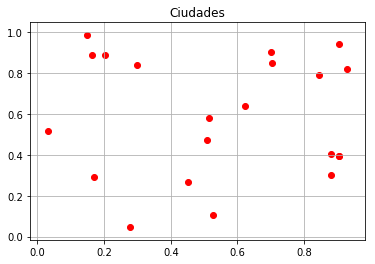

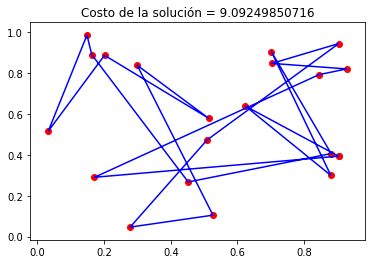

In [4]:
# Inicializamos el generador de números aleatorios de numpy
np.random.seed(2019)
# Generamos una instancia del problema del Agente Viajero
tsp = TSP(n=20)
# Mostramos las ciudades del problema
tsp.show()
# Mostramos una posible permutación de las ciudades
permutacion  = list(range(20))
tsp.show(permutacion)

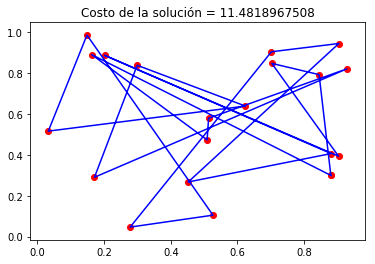

In [5]:
import random as rd
# inicializamos la semilla de random
rd.seed(2017)
#
# una permutación distinta tendrá otro costo
rd.shuffle(permutacion)
tsp.show(permutacion)

Observamos que esta nueva solución tiene un costo mayor.

Ahora vamos a ver como usar SA para solucionar el problema.

Necesitamos que el problema implemente los métodos de una Búsqueda Local. Así creamos el problema del Agente Viajero que extiende de TSP.

In [6]:

import random
from random import randint
class TSP_LS(TSP,LocalSearchProblem):
    """
    Problema del Agente Viajero 
    como un problema de búsqueda local
    """
    def __init__(self,n=10):
        """
        Construye el problema del agente viajero con ciudades aleatorias
        :param n: número de ciudades
        """
        # invocamos el constructor de TSP
        TSP.__init__(self,n)
        
    def aleatoria(self):
        """
        Un estado aleatorio
        :return: el estado
        """
        conf = list(range(0,self.n))
        random.shuffle(conf)
        return conf
        
    def energia(self,x):
        """
        La energía de un estado
        :param x: la permutación de ciudades
        :return: el costo de la ruta
        """
        return self.compute_cost(x)
        
    def move(self,x):
        """
        Una solución vecina aleatoria
        :param x: la permutación de referencia
        :
        """
        # creamos una copia para no alterar
        # la solución original
        xp = x.copy()
        i=randint(0,self.n-1)
        j=randint(0,self.n-1)
        
        xp[i],xp[j]=xp[j],xp[i]
        
        return xp

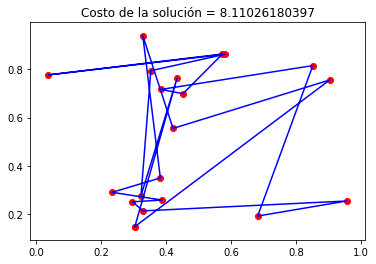

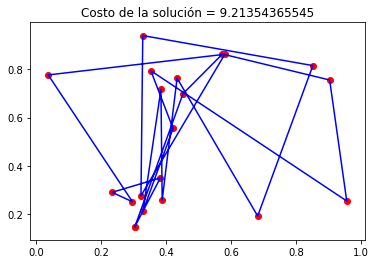

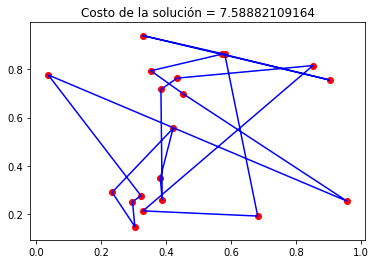

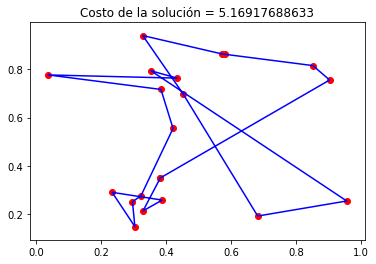

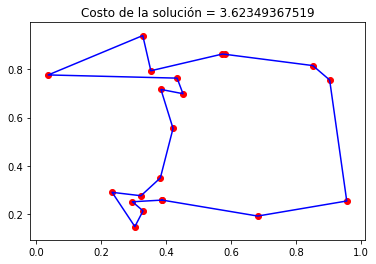

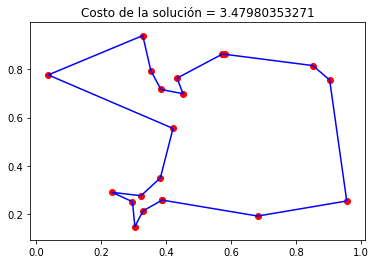

In [7]:
# Procedemos a probar el algoritmo SA en el problema TSP
tsp = TSP_LS(n=20)
# El parámetro K es para mostrar como va la solución tras K iteraciones de enfriamiento
solucion,costo = SimulatedAnnealing.search(problema=tsp,c_enfriamiento=0.99,Tinit=5,Tend=0.01,n=20,K=120)

In [8]:
print("La solución encontrada: ",solucion)
print("El costo de la solución:",costo)

La solución encontrada:  [19, 3, 18, 17, 13, 4, 1, 14, 10, 9, 11, 7, 8, 16, 6, 2, 5, 12, 0, 15]
El costo de la solución: 3.47980353271


## Algoritmo genético para problemas de recombinación

Ahora vamos a construir un algoritmo genético para problemas de recombinación en una versión básica.

### Entorno

Comencemos por definir el Entorno. Un Entorno o Medio Ambiente correspondera a un problema a resolver.

Usaremos la clase __Environment__.

In [1]:
from abc import ABCMeta, abstractmethod
class Environment:
    """
    Entorno define los métodos que deben ser implementados 
    Por una instancia del problema a resolver
    """
    __metaclass__ = ABCMeta
    
    @abstractmethod
    def evaluate(self,population):
        """
        Evalua los individuos de la población asignándoles su aptitud
        :param: la población de individuos
        """
        pass
        
    @abstractmethod
    def decode(self,population):
        """
        Decodifica los individuos de una población 
        generando para cada uno de ellos un fenotipo de acuerdo a su genotipo
        El fenotipo se asigna al organismo.
        :parama
        """
        pass
        
    @abstractmethod
    def get_chromosome_length(self):
        """
        Define cuantos bits se requieren para representar el cromosoma de un
        organismo
        :return: el número de bits
        """
        pass

### Genotipo

La información genética de un individuo esta en su genotipo. Aunque para el algoritmo genético usado para resolver problemas de permutación la codificación no es necesaria, aquí incluimos la clase por completez.

Usaremos la clase __Genotype__.

In [2]:
from struct import unpack
from os import urandom
from functools import reduce
from math import ceil

class Genotype:
    """
    El genotipo de un organismo
    """
    def __init__(self,n,chromosome=None):
        """
        Construye el genotipo de un organismo
        :param n: el número de bits del cromosoma binario
        :param chromosome: un cromosoma de referencia a partir
        del cual se creará el nuevo genotipo
        """
        # establecemos el número de bits
        self.n = n
        # si tenemos un cromosoma lo establecemos
        # la información del cromosoma esta contenida en un entero
        # los bits del entero representan el cromosoma
        if(chromosome != None):
            self.chromosome = chromosome
        else:
            # genera la información genética de manera aleatoria
            if(self.n==64):
                # el generador de números aleatorios nos da 8 bytes
                chromosome = unpack("!Q",urandom(8))[0]
            elif(self.n<64):
                # recortamos al número exacto de bits
                chromosome = unpack("!Q",urandom(8))[0] & \
                ((1<<self.n)-1)
            else:
                # generamos varias lecturas de 64 bits para generar
                # un cromosoma de longitud mayor
                m = ceil(self.n/64)
                rand = [0]+[unpack("!Q",urandom(8))[0] for i in range(0,m)]
                chromosome = reduce(lambda x,y:(x<<64)|y,rand) &\
                ((1<<self.n)-1)
            # establecemos el cromosoma
            self.chromosome = chromosome
    
    def __str__(self):
        """
        representación en cadena del genotipo
        :return: la cadena de unos y ceros
        """
        return ("{0:0"+str(self.n)+"b}").format(self.chromosome)

    def __repr__(self):
        """
        Representación del objeto en impresiones
        """
        return str(self)

In [3]:
# Creamos un genotipo aleatorio de 50 bits
genotipo = Genotype(50)
print("Genotipo:",genotipo)

Genotipo: 11100001000010011000000100110001100100110110010011


### Organismo

El organismo estará formado por un genotipo y un fenotipo.

Usamos la clase __Organism__.

In [4]:

class Organism:
    
    """
    Organismo artificial
    """
    def __init__(self,genotype=None,phenotype=None):
        """
        Crea el organismo
        """
        # establece el genotipo
        self.genotype = genotype
        # establece el fenotipo
        self.phenotype = phenotype
        
    def __str__(self):
        """
        Convierte a cadena la información del organismo
        """
        # Observamos que si la aptitud (fitness) esta definida
        # la incluye en la información de la cadena
        return  \
        (('genotype: '+ str(self.genotype)) \
        if self.genotype is not None else '') + \
        (('phenotype: '+ str(self.phenotype)) \
        if self.phenotype is not None else '') + \
        (('fitness: ' + str(self.fitness)) \
        if hasattr(self,'fitness') else '')
        
    def __repr__(self):
        """
        Representación del objeto en impresiones
        """
        return str(self)
        

### Población

Los algoritmos genéticos están basados en poblaciones de organismos.

Vamos a crear una población con la clase __Population__.

In [5]:
from numpy import random
import numpy as np
class Population:
    """
    Una población de organismos
    """
    
    def __init__(self,environment,parameters,individuals=None):
        """
        Crea la población de organismos
        :param environment: el problema o entorno para los organismos
        :param parameters: un diccionario con los parámetros del algoritmo
        :param individuals: los individuos de la población a crear
        """
        self.environment = environment
        self.parameters = parameters
        # Extrae el número de individuos u organismos
        self.size = self.parameters['n.individuals']
        
        if individuals==None:
            # Si no se especificó a los miembros se crean nuevos organismos
            self.individuals = [self.create_individual() \
            for i in range(0,self.parameters['n.individuals'])]
        else:
            # Si se especifican, se asignan a la población
            self.individuals = individuals
            # El tamaño de la población es el número de organismos
            self.size = len(individuals)

        
    def create_individual(self):
        """
        Crea un individuo 
        :return: el nuevo organismo
        """
        # Si se trata de un problema de permutación esto se le indica
        # al algoritmo usando la llave 'type' con valor 'permutation'
        if(self.parameters['type']=='permutation'):
            # En este caso creamos el fenotipo como una permutación de enteros
            # entre 0 y N-1, con N el tamaño del cromosoma definido en el 
            # problema
            phen = \
            np.array(list(range(0,self.environment.get_chromosome_length())))
            # desordenamos la lista
            random.shuffle(phen)
            # creamos el individuo con el fenotipo generado
            individual = Organism(phenotype=phen)
        else:
            # En este caso creamos un nuevo genotipo aleatorio y creamos
            # un organismo con dicho genotipo
            individual = \
            Organism(Genotype(self.environment.get_chromosome_length()))
        return individual
        
    def __str__(self):
        """
        Una cadena con la información de cada organismo
        :return: una cadena con la información de los organismos de la población
        """
        return "\n".join([str(i) for i in self.individuals])
    
    def __repr__(self):
        """
        Representación del objeto para impresión
        """
        return str(self)

### Selección

Creamos una clase con las funciones para selección artificial de organismos.

In [6]:
from functools import reduce
from numpy import random,sort,cumsum
from random import choice,shuffle
from math import ceil,sqrt
class Selection:
    
    """
    Operadores de selección artificial de organismos
    """
    @staticmethod
    def tournament(population):
        """
        Selección tipo torneo
        :param population: la población de organismos
        :return: la población de organismos seleccionados para reproducción
        """
        # El tamaño del torneo se obtiene de los parametros del algoritmo
        # estos se consultan de la población
        k = population.parameters['tournament.size']
        # Se crea una nueva población
        # Seleccionamos torneos y el ganador es el de fitness máximo
        return  Population(population.environment, population.parameters,\
        [max([choice(population.individuals) \
        for i in range(0,k)],key=lambda x:x.fitness)\
        for i in range(0,population.size)])
    
            
    @staticmethod
    def roulettewheel(population):
        """
        Selección tipo ruleta
        :param population: la población de organismos
        :return: la población de organismos seleccionados para reproducción
        """
        # calculamos los apuntadores de selección de la ruleta
        pointers = sort(random.uniform(size=population.size))
        # la suma de las aptitudes de la población
        total_fitness = reduce(lambda x,y:x+y, \
        map(lambda i:i.fitness,population.individuals))
        # las probabilidades de selección
        probabilities = map(lambda x:x.fitness/total_fitness, \
        population.individuals)
        # lista para el resultado de la selección
        selected = []
        # los delimitadores de región para cada individuo
        delimiters = cumsum(list(probabilities))
        
        # dos apuntadores que iremos corriendo
        i_p = 0
        i_d = 0
        while i_p < population.size and i_d < population.size:
            while i_p < population.size and pointers[i_p] < delimiters[i_d]:
                # seleccionamos al individuo mientras haya apuntadores en su región
                selected=selected+[population.individuals[i_d]]
                # siguiente apuntador
                i_p = i_p + 1
            # siguiente individuo
            i_d = i_d + 1
        # desordenamos los organismos seleccionados
        shuffle(selected)
        # una nueva población a partir de los seleccionados
        return  Population(population.environment, population.parameters,\
        selected)
        

### Operadores genéticos

Vamos a definir una clase para los operadores genéticos de cruza y mutación.

En nuestra aplicación a problemas de permutación definimos un operador especial para la cruza de soluciones. Aquí vamos a presentar varios operadores de cruza. 

In [7]:
from numpy import random
import numpy as np
class PermutationCrossover:
    
    """
    Cruzas para problemas de permutación. Ver referencias [1,2]
    """
    
    @staticmethod
    def pmx_crossover(individual1,individual2):
        """
        Partially-mapped crossover
        :param individual1: primer padre
        :parma individual2: segundo padre
        :return: una lista con dos hijos
        """
        n,i,f,i_central,i_sides= PermutationCrossover.mapping_sections(\
        individual1,individual2)
        child1,child2 = PermutationCrossover.child_templates(n)
        map_1_2,map_2_1 = PermutationCrossover.find_mappings(\
        i_central,individual1,individual2)
        
        child1[i_central]= individual2.phenotype[i_central]
        child2[i_central]= individual1.phenotype[i_central] 

        sides = list(filter(lambda x: x not in i_central,\
        range(0,n)))        
        
        child1[sides] = [i if i not in map_2_1.keys() else\
        PermutationCrossover.alternative(i,map_2_1) \
        for i in individual1.phenotype[sides]]
        child2[sides] = [i if i not in map_1_2.keys() else\
        PermutationCrossover.alternative(i,map_1_2) \
        for i in individual2.phenotype[sides]]
        return [Organism(phenotype=child1),Organism(phenotype=child2)]
        
    @staticmethod
    def cx_crossover(individual1,individual2):
        """
        Partially-mapped crossover
        :param individual1: primer padre
        :param individual2: segundo padre
        :return: una lista con dos hijos
        """
        n = len(individual1.phenotype)
        child1= individual2.phenotype.copy()
        child2= individual1.phenotype.copy()
        city_pos = 0
        map_1 = {individual1.phenotype[i]:i for i in range(0,n)}
        while(True):
            city_pos = PermutationCrossover.apply_mapping(\
            child1,child2,individual1,individual2,city_pos,map_1)
            if(map_1[individual2.phenotype[city_pos]] is 0):
                PermutationCrossover.apply_mapping(\
                child1,child2,individual1,individual2,city_pos,map_1)
                break
        return  [Organism(phenotype=child1),Organism(phenotype=child2)]
        
    @staticmethod
    def apply_mapping(child1,child2,individual1,individual2,city_pos,map_1):
        child1[city_pos] = individual1.phenotype[city_pos]
        child2[city_pos] = individual2.phenotype[city_pos]
        return map_1[individual2.phenotype[city_pos]]
              
    @staticmethod
    def ox_crossover(individual1,individual2):
        """
        Order crossover  
        :param individual1: primer padre
        :parma individual2: segundo padre
        :return: una lista con dos hijos
        """
        n,i,f,i_central,i_sides= PermutationCrossover.mapping_sections(\
        individual1,individual2)
        
        p1_central = set(individual1.phenotype[i_central])
        p2_central = set(individual2.phenotype[i_central])
        centrals = p1_central.union(p2_central)
        
        rest_1 = list(filter(lambda x:x[1] not in centrals, \
        enumerate(individual1.phenotype)))
        rest_2 = list(filter(lambda x:x[1] not in centrals, \
        enumerate(individual2.phenotype)))
        
        rest_1 = np.array([x[1] for x in \
        list(filter(lambda x:x[0]>=f,rest_1))+\
        (list(filter(lambda x:x[0]<i,rest_1)))])

        rest_2 = np.array([x[1] for x in \
        list(filter(lambda x:x[0]>=f,rest_2))+\
        (list(filter(lambda x:x[0]<i,rest_2)))])
        
        head_1 = np.array(list(filter(lambda x:x not in p2_central,\
        individual1.phenotype[i_central])))
        
        head_2 = np.array(list(filter(lambda x:x not in p1_central,\
        individual2.phenotype[i_central])))
        
        child1 = PermutationCrossover.build_child(\
        head_1,individual2.phenotype[i_central],rest_1)
        
        child2= PermutationCrossover.build_child(\
        head_2,individual1.phenotype[i_central],rest_2)
         
        return [Organism(phenotype=child1),Organism(phenotype=child2)]
        
    @staticmethod
    def build_child(head,middle,rest):
        if head.size>0 and rest.size>0:
            return np.concatenate((head,middle,rest))
        elif head.size>0 and rest.size==0:
            return np.concatenate((head,middle))
        elif head.size==0 and rest.size>0:
            return np.concatenate((middle,rest))
        else:
            return middle
        
        
    @staticmethod
    def ox1_crossover(individual1,individual2):
        """
        Cruza OX1
        :param individual1: primer padre
        :parma individual2: segundo padre
        :return: una lista con dos hijos
        """
        n,i,f,i_central,i_sides= PermutationCrossover.mapping_sections(\
        individual1,individual2)
        child1,child2 = PermutationCrossover.child_templates(n) 

        p1_central = set(individual1.phenotype[i_central])
        p2_central = set(individual2.phenotype[i_central])

        child1[i_central]= individual1.phenotype[i_central]
        child2[i_central]= individual2.phenotype[i_central]        
        child1[i_sides[:n-(f-i)-1]] = list(filter(lambda x:x not in p1_central,\
        individual2.phenotype[i_sides]))
        child2[i_sides[:n-(f-i)-1]] = list(filter(lambda x:x not in p2_central,\
        individual1.phenotype[i_sides])) 
        return [Organism(phenotype=child1),Organism(phenotype=child2)]
        
    @staticmethod
    def ox2_crossover(individual1,individual2):
        """
        Cruza OX2
        :param individual1: primer padre
        :parma individual2: segundo padre
        :return: una lista con dos hijos
        """
        n,poss = PermutationCrossover.random_crossover_points(\
        individual1,individual2)

        child1 = np.copy(individual1.phenotype)
        child2 = np.copy(individual2.phenotype)
        
        p_1 = individual1.phenotype[poss]
        p_2 = individual2.phenotype[poss]

        pos_1 = [i[0] for i in enumerate(individual1.phenotype) \
        if i[1] in set(p_2)]
        pos_2 = [i[0] for i in enumerate(individual2.phenotype) \
        if i[1] in set(p_1)]
        child1[pos_1]= p_2    
        child2[pos_2]= p_1
        return [Organism(phenotype=child1),Organism(phenotype=child2)]

    @staticmethod
    def random_crossover_points(individual1,individual2):
        n = len(individual1.phenotype)
        #sorted unique indices 
        poss = np.unique(np.random.choice(list(range(0,n)),\
        np.random.randint(1,n)))        
        return (n,poss)
        
    @staticmethod
    def pos_crossover(individual1,individual2):
        """
        Cruza posicional
        :param individual1: primer padre
        :parma individual2: segundo padre
        :return: una lista con dos hijos
        """
        n,poss = PermutationCrossover.random_crossover_points(\
        individual1,individual2)
        child1,child2 = PermutationCrossover.child_templates(n)
        
        child1[poss]=individual2.phenotype[poss]
        child2[poss]=individual1.phenotype[poss]

        
        poss_set = set(poss)        
        p1_sel = set(individual1.phenotype[poss])
        p2_sel = set(individual2.phenotype[poss])
        pos_res = list(filter(lambda x:x not in poss_set,range(0,n)))

        rest_1 = list(filter(lambda x:x not in p2_sel,individual1.phenotype))
            
        rest_2 = list(filter(lambda x:x not in p1_sel,individual2.phenotype))

        child1[pos_res] = rest_1
        child2[pos_res] = rest_2
        return [Organism(phenotype=child1),Organism(phenotype=child2)]
        
    @staticmethod
    def pmx_grefenstette_crossover(individual1,individual2):
        """
        Cruza Grefenstette
        :param individual1: primer padre
        :parma individual2: segundo padre
        :return: una lista con dos hijos
        """
        n,i,f,i_central,i_sides= PermutationCrossover.mapping_sections(\
        individual1,individual2)
        child1_central = individual2.phenotype[i_central]
        child2_central = individual1.phenotype[i_central]
        p1_central = set(child1_central)
        p2_central = set(child2_central)
        child1_rest = np.array(list(filter(lambda x:x not in p1_central,\
        individual1.phenotype)))
        child2_rest = np.array(list(filter(lambda x:x not in p2_central,\
        individual1.phenotype)))
        pos_1 = np.where(individual1.phenotype==child1_central[0])[0][0]
        pos_2 = np.where(individual2.phenotype==child2_central[0])[0][0]
        child1 = PermutationCrossover.build_child(child1_rest[:pos_1],\
        child1_central,child1_rest[pos_1:])
        child2 = PermutationCrossover.build_child(child2_rest[:pos_2],\
        child2_central,child2_rest[pos_2:])
        return [Organism(phenotype=child1),Organism(phenotype=child2)]
        
    @staticmethod
    def mapping_sections(individual1,individual2):
        n = len(individual1.phenotype)
        i,f = np.sort(random.randint(0,n,2))
        i_central = list(range(i,f+1))
        i_sides = [i%n for i in range(f+1,n+f+1)]
        return (n,i,f,i_central,i_sides)
        
    @staticmethod
    def find_mappings(i_central,individual1,individual2):
        map_1_2 = {individual1.phenotype[i]:individual2.phenotype[i] \
        for i in i_central}
        map_2_1 = {individual2.phenotype[i]:individual1.phenotype[i] \
        for i in i_central}
        return (map_1_2,map_2_1)
        
    @staticmethod
    def alternative(city,map):
        while(city in map.keys()):
            city = map[city]
        return city
        
        
    @staticmethod
    def child_templates(n):
        return ( np.array([0]*n), np.array([0]*n))

In [8]:
from random import randint
from numpy import random
import numpy as np
class GeneticOperators: 
    
    # los tipos de selección
    selections={"tournament.selection":Selection.tournament,
                "roulettewheel.selection":Selection.roulettewheel}  
                
    # los tipos de cruza para problemas de permutación
    permutations={"permutation.ox":PermutationCrossover.ox_crossover,
                  "permutation.ox1":PermutationCrossover.ox1_crossover,
                  "permutation.ox2":PermutationCrossover.ox2_crossover,
                  "permutation.pmx":PermutationCrossover.pmx_crossover,
                  "permutation.pmx.grefenstette":
                      PermutationCrossover.pmx_grefenstette_crossover,
                  "permutation.pos":PermutationCrossover.pos_crossover,
                  "permutation.cx":PermutationCrossover.cx_crossover}
    
    keys = list(permutations.keys())
    
    @staticmethod
    def crossover(population):
        """
        Realiza la cruza de los individuos de la población
        :param population: la población a cruzar
        """
        # asume que los individuos están desordenados en la población
        new_pop = []
        for i in range(0,population.size>>1):
            individual1 = population.individuals[i]
            individual2 = population.individuals[population.size-i-1]
            # la probabilidad de cruza es 'p.crossover'
            if(random.uniform() < population.parameters['p.crossover']):
                # el tipo de cruza es 'crossover.type'
                # se puden usar todos los operadores de cruza 
                # de manera aleatoria
                type = population.parameters['crossover.type'] \
                if (population.parameters['crossover.type'] \
                != 'permutation.all.operators') else \
                np.random.choice(GeneticOperators.keys)
                children = GeneticOperators.permutation_crossover_individuals(\
                individual1,individual2,type) \
                if(population.parameters['type']=='permutation') else \
                GeneticOperators.crossover_individuals(\
                individual1,individual2)
            else:
                children = [\
                Organism(individual1.genotype,\
                np.array(individual1.phenotype)),\
                Organism(individual2.genotype,\
                np.array(individual2.phenotype))]
            new_pop = new_pop + children
        # regresamos la población cruzada
        return \
        Population(population.environment, population.parameters,new_pop)
    
    @staticmethod
    def crossover_individuals(individual1,individual2):
        """
        Cruza de dos organismos
        :param individual1: el primer padre
        :param individual2: el segundo padre
        :return: una lista con dos nuevos individuos hijos
        """
        genotype1 = individual1.genotype
        genotype2 = individual2.genotype
        # el punto de cruza
        crossp = randint(1,genotype1.n-1)
        mask1 = ((1<<(genotype1.n-crossp))-1)<< crossp
        mask2 = (1<<crossp)-1
        # la cruza a nivel de bits
        ch1 = mask1&genotype1.chromosome|mask2&genotype2.chromosome
        ch2 = mask1&genotype2.chromosome|mask2&genotype1.chromosome
        child1 = Genotype(genotype1.n,ch1)
        child2 = Genotype(genotype1.n,ch2)
        return [Organism(child1),Organism(child2)]
        
    @staticmethod
    def permutation_crossover_individuals(individual1,individual2,type):
        # cuando es problema de permutación delegamos el cómputo
        # a los operadores correspondientes
        return GeneticOperators.permutations[type](individual1,individual2)
        
    @staticmethod
    def mutate_in_place(population):
        """
        Realiza la mutación en el mismo objeto
        :param population: la población a mutar
        """
        # caso de permutación
        if(population.parameters['type']=='permutation'):
            length = len(population.individuals[0].phenotype)
            # usamos una distribución binomial, es más eficiente
            # esta distribuión nos da el número de mutaciones a
            # aplicar
            mutations = random.binomial(length*population.size,\
            population.parameters['p.mutation'])
            to_mutate = [(randint(0,population.size-1),randint(0,length-1),\
            randint(0,length-1)) for i in range(0,mutations)]
            for ind,a,b in to_mutate:
                temp = population.individuals[ind].phenotype[a]
                population.individuals[ind].phenotype[a] = \
                population.individuals[ind].phenotype[b]
                population.individuals[ind].phenotype[b] = temp
        # caso clásico
        else:
            length = population.environment.get_chromosome_length();
            mutations = random.binomial(length*population.size,\
            population.parameters['p.mutation'])
            to_mutate = [(randint(0,population.size-1),randint(0,length-1)) \
            for i in range(0,mutations)]
            for ind,pos in to_mutate:
                population.individuals[ind].genotype.chromosome = \
                population.individuals[ind].genotype.chromosome^(1<<pos)
            
    @staticmethod
    def select(population):
        """
        Selecciona a los más aptos
        :param population: la población de organismos
        """
        # se delega la selección de acuerdo al parámetro
        # establecido en la llave 'selection.type'
        selection_method = \
        GeneticOperators.selections[population.parameters['selection.type']]
        return selection_method(population)
            

## El algoritmo genético

Ahora articulamos los pasos en la clase __GeneticAlgorithm__.

In [9]:

import warnings
class GeneticAlgorithm:
    def __init__(self,environment,parameters):
        self.parameters = parameters
        self.environment = environment
        self.population = Population(environment,parameters)
        self.environment.decode(self.population)
        self.environment.evaluate(self.population)
        
    def evolve(self):
        for i in range(0,self.parameters['n.generations']):
            mating_pool = GeneticOperators.select(self.population)       
            new_pop = GeneticOperators.crossover(mating_pool)
            GeneticOperators.mutate_in_place(new_pop)
            self.environment.decode(new_pop)
            self.environment.evaluate(new_pop)               
            self.population = new_pop
            # para reportar avance
            self.report(i,self.parameters['n.generations'])
            
        self.report()
                
    def report(self,generation=0,total=0):
        step = max(1,int(total/10))
        progress = int(generation/step) if step != 0 else 100
        if(generation==total):
            print('\r'*80+'Done'+' '*76)
        elif(generation%step==0):
            print('\r'*80+"Progress: {num:02d}%".format(\
            num=progress*10)+\
            " ["+chr(187)*int(progress*5)+chr(183)*(10*5-int(progress*5))+\
            "]",end="")


### TSP como un entorno de organismos

Para poder probar el algoritmo tenemos que crear el problema como un entorno.

Para ello creamos una nueva clase para el TSP que se comporte como Entorno.

In [10]:
class TSP_Environment(TSP,Environment):
    
    def __init__(self,n=10):
        super().__init__(n)
        
    def evaluate(self,population):
        """
        Evaluación de individuos de la población
        """
        # la aptitud será el inverso del costo
        for individual in population.individuals:
            individual.fitness = 1/self.compute_cost(individual.phenotype)
        
    def decode(self,population):
        """
        Decodificación. En problemas de permutación no decodificamos
        """
        pass
        
    def get_chromosome_length(self):
        """
        Longitud del cromosoma
        :return: en el TSP el número de ciudades
        """
        return self.n   


NameError: name 'TSP' is not defined

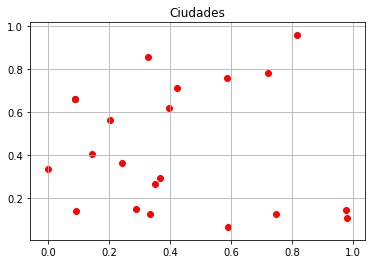

In [19]:
# Vamos a crear un nuevo entorno con 20 ciudades
tsp_ga = TSP_Environment(20)
tsp_ga.show()

[19  9  1 15  3  6  0  4 16 17 13  8  5 12 18  7 11 10  2 14]


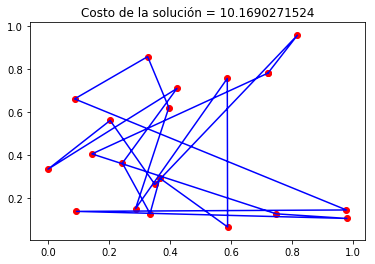

[13  0 10  3 16  5 15  4 12  9  2  1 14  7 11  6 18 19  8 17]


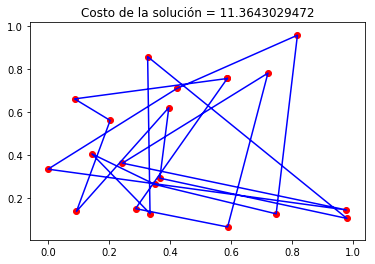

[17  1  2  9  3  8  5  0 10 15 13 14  7  6 11 18  4 12 19 16]


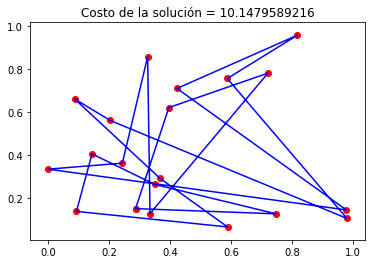

[14  7 13 15  2 11 10 12 18 19  3  9  5  4  1 17  0  6  8 16]


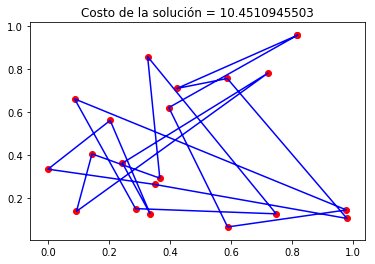

[ 0  2 12  8  9 11 19 18  3  7  1 14  6 17  5 15 10 13  4 16]


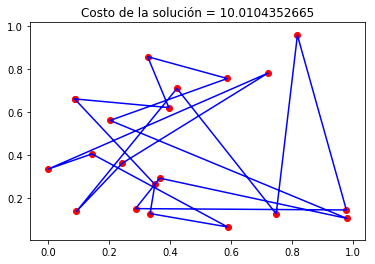

In [20]:
#Ahora vamos a crear los paramétros del algoritmo genético

parametros = {
    "type":"permutation",
    "n.individuals":100,
    "n.generations":100,
    "p.mutation":1/20,
    "p.crossover":0.9,
    "crossover.type":"permutation.all.operators",
    "selection.type":"roulettewheel.selection"
}

# Creamos el algoritmo genético
ga = GeneticAlgorithm(environment=tsp_ga,parameters=parametros)
# Visualizamos 5 de las soluciones de la población inicial
N= 5
for i in range(N):
    organism = ga.population.individuals[parametros["n.individuals"]//N*i].phenotype
    print(organism)
    tsp_ga.show(permutation=organism)

In [21]:
# definamos una función para mostrar información importante de la población

def stats(ga):
    # podemos calcular el promedio del costo, el mejor y peor costo
    print("Mejor costo:",
      tsp_ga.compute_cost(max(ga.population.individuals,key=lambda i:i.fitness).phenotype))
    print("Peor costo:",
      tsp_ga.compute_cost(min(ga.population.individuals,key=lambda i:i.fitness).phenotype))
    print("Promedio de costo:",
      sum(map(lambda i:tsp_ga.compute_cost(i.phenotype),ga.population.individuals))/ga.population.size)
    
# invocamos la función
stats(ga)

Mejor costo: 8.05842341062
Peor costo: 12.5587544471
Promedio de costo: 10.4803309253


In [22]:
# Ahora vamos a evolucionar la población
ga.evolve()

Done                                                                            


In [23]:
# podemos calcular el promedio del costo, el mejor y peor costo tras la evolución
stats(ga)

Mejor costo: 7.60441483383
Peor costo: 12.8219592211
Promedio de costo: 10.3871461977


In [24]:
# observamos que hay una ligera mejora en el valor promedio de costo y el mejor costo
# Ahora vamos a ver el efecto de los parámetros del algoritmo
# primero el número de iteraciones, ahora lo iteraremos 1000 veces
parametros["n.generations"]=1000

# creamos nuevamente el algoritmo genético:
ga = GeneticAlgorithm(environment=tsp_ga,parameters=parametros)
print("Población inicial:")
stats(ga)
# evolucionamos
ga.evolve()
print("Tras 1000 generaciones:")
stats(ga)

Población inicial:
Mejor costo: 7.91232113007
Peor costo: 12.710744056
Promedio de costo: 10.5928628934
Done                                                                            
Tras 1000 generaciones:
Mejor costo: 7.37357449905
Peor costo: 12.4173266468
Promedio de costo: 10.2692510063


In [25]:
# Ahora vamos a cambiar la selección a torneo
parametros["selection.type"]="tournament.selection"
# Primero probaremos con torneos binarios
parametros["tournament.size"]=2
# creamos nuevamente el algoritmo genético:
ga = GeneticAlgorithm(environment=tsp_ga,parameters=parametros)
print("Población inicial:")
stats(ga)
# evolucionamos
ga.evolve()
print("Tras 1000 generaciones:")
stats(ga)

Población inicial:
Mejor costo: 8.28421040349
Peor costo: 12.4549721333
Promedio de costo: 10.6132166118
Done                                                                            
Tras 1000 generaciones:
Mejor costo: 7.75142047824
Peor costo: 12.8308785648
Promedio de costo: 10.0326076289


In [26]:
# Repetiremos el experimento con un torneo más grande
# incrementando con ello la presión de selección
parametros["tournament.size"]=15
# creamos nuevamente el algoritmo genético:
ga = GeneticAlgorithm(environment=tsp_ga,parameters=parametros)
print("Población inicial:")
stats(ga)
# evolucionamos
ga.evolve()
print("Tras 1000 generaciones:")
stats(ga)

Población inicial:
Mejor costo: 7.54961315405
Peor costo: 12.4320911325
Promedio de costo: 10.6537768883
Done                                                                            
Tras 1000 generaciones:
Mejor costo: 4.17004139124
Peor costo: 8.96307513278
Promedio de costo: 5.30571926277


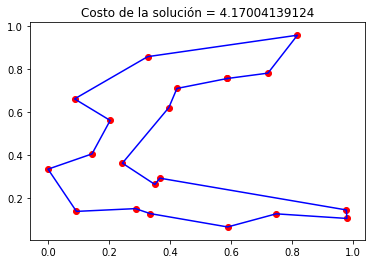

In [28]:
#Mostremos la mejor solución
tsp_ga.show(max(ga.population.individuals,key=lambda i:i.fitness).phenotype)

Población inicial:
Mejor costo: 6.85910921678
Peor costo: 11.1453471937
Promedio de costo: 9.22614332264
Done                                                                            
Tras 1000 generaciones:
Mejor costo: 3.43495056741
Peor costo: 9.10695316921
Promedio de costo: 4.44371451229


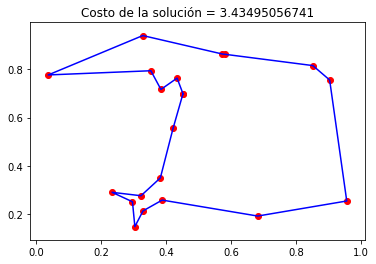

In [29]:
# Finalmente, con estos parámetros podemos comparar contra el problema resuelto
# con el algoritmo SA
tsp_ga.cities = tsp.cities
# creamos nuevamente el algoritmo genético:
ga = GeneticAlgorithm(environment=tsp_ga,parameters=parametros)
print("Población inicial:")
stats(ga)
# evolucionamos
ga.evolve()
print("Tras 1000 generaciones:")
stats(ga)
#Mostremos la mejor solución
tsp_ga.show(max(ga.population.individuals,key=lambda i:i.fitness).phenotype)

## Referencias

[1] Abdoun, O., & Abouchabaka, J. (2012). A comparative study of adaptive crossover operators for genetic algorithms to resolve the traveling salesman problem. arXiv preprint arXiv:1203.3097.

[2] David Edward Goldberg et al. Genetic algorithms in search, optimization, and machine
learning, volume 412. Addison-wesley Reading Menlo Park, 1989. Cubre el tema de
algoritmos genéticos.